# TB Interventions Tutorial

This notebook demonstrates how to create and run tuberculosis (TB) simulations with various interventions using the `tbsim` and `starsim` libraries. We'll explore different intervention strategies including BCG vaccination and Tuberculosis Preventive Therapy (TPT).

## Overview

In this tutorial, you will learn:

1. **Building TB simulations** with intervention capabilities
2. **Defining different intervention scenarios** (BCG, TPT, Beta changes)
3. **Running multiple scenarios** and comparing results
4. **Visualizing intervention impacts** on TB transmission

The tutorial is based on the `run_tb_interventions.py` script and provides a comprehensive introduction to TB intervention modeling.

## Required Packages

First, let's import the necessary libraries:

In [1]:
import tbsim as mtb
import starsim as ss
import sciris as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Default Parameters

Let's define the default parameters for our simulations:

In [2]:
# Simple default parameters for simulation
DEFAULT_SPARS = dict(
    
    dt=ss.days(7),
    start=ss.date('1975-01-01'),
    stop=ss.date('2030-12-31'),
    rand_seed=123,
    verbose=0,
)

# Default TB parameters
DEFAULT_TBPARS = dict(
    beta=0.0025,  # Use simple float value
    init_prev=0.25,  # Use simple float value
    
    dt=ss.days(7),      
    start=ss.date('1975-02-01'),
    stop=ss.date('2030-12-31'),
)

# Simple age distribution
age_data = pd.DataFrame({
    'age': [0, 2, 4, 10, 15, 20, 30, 40, 50, 60, 70, 80],
    'value': [20, 10, 25, 15, 10, 5, 4, 3, 2, 1, 1, 1]  # Skewed toward younger ages
})

print("Default simulation parameters:")
for key, value in DEFAULT_SPARS.items():
    print(f"  {key}: {value}")

print("\nDefault TB parameters:")
for key, value in DEFAULT_TBPARS.items():
    print(f"  {key}: {value}")

print("\nAge distribution:")
print(age_data)

Default simulation parameters:
  dt: days(7)
  start: 1975.01.01
  stop: 2030.12.31
  rand_seed: 123
  verbose: 0

Default TB parameters:
  beta: 0.0025
  init_prev: 0.25
  dt: days(7)
  start: 1975.02.01
  stop: 2030.12.31

Age distribution:
    age  value
0     0     20
1     2     10
2     4     25
3    10     15
4    15     10
5    20      5
6    30      4
7    40      3
8    50      2
9    60      1
10   70      1
11   80      1


## Building the Simulation Function

Now let's create a function that builds a complete TB simulation with intervention capabilities:

In [3]:
def build_sim(scenario=None, spars=None):
    """
    Build and return a complete Starsim-based simulation instance for TB modeling,
    incorporating optional interventions and user-defined parameters.
    
    Args:
        scenario (dict, optional): A dictionary defining scenario-specific components,
            such as intervention parameters and TB simulation settings.
        spars (dict, optional): General simulation parameters.
    
    Returns:
        ss.Sim: A fully initialized simulation object
    """
    scenario = scenario or {}
    
    # Merge parameters
    spars = {**DEFAULT_SPARS, **(spars or {})}
    tbpars = {**DEFAULT_TBPARS, **(scenario.get('tbpars') or {})}
    
    # Create interventions list
    interventions = []
    
    # Add BCG interventions (can be single or multiple)
    bcg_params = scenario.get('bcgintervention')
    if bcg_params:
        if isinstance(bcg_params, dict):
            # Single BCG intervention
            interventions.append(mtb.BCGProtection(pars=bcg_params))
        elif isinstance(bcg_params, list):
            # Multiple BCG interventions
            for i, params in enumerate(bcg_params):
                params['name'] = f'BCG_{i}'  # Give unique name
                interventions.append(mtb.BCGProtection(pars=params))
    
    # Add TPT interventions (can be single or multiple)
    tpt_params = scenario.get('tptintervention')
    if tpt_params:
        if isinstance(tpt_params, dict):
            # Single TPT intervention
            interventions.append(mtb.TPTInitiation(pars=tpt_params))
        elif isinstance(tpt_params, list):
            # Multiple TPT interventions
            for i, params in enumerate(tpt_params):
                params['name'] = f'TPT_{i}'  # Give unique name
                interventions.append(mtb.TPTInitiation(pars=params))
    
    # Add Beta interventions (can be single or multiple)
    beta_params = scenario.get('betabyyear')
    if beta_params:
        if isinstance(beta_params, dict):
            # Single Beta intervention
            interventions.append(mtb.BetaByYear(pars=beta_params))
        elif isinstance(beta_params, list):
            # Multiple Beta interventions
            for i, params in enumerate(beta_params):
                params['name'] = f'Beta_{i}'  # Give unique name
                interventions.append(mtb.BetaByYear(pars=params))
    
    # Create simulation components
    pop = ss.People(n_agents=500, age_data=age_data)
    tb = mtb.TB(pars=tbpars)
    networks = [
        ss.RandomNet({'n_contacts': ss.poisson(lam=5), 'dur': 0})
    ]
    
    # Create and return simulation
    return ss.Sim(
        people=pop,
        networks=networks,
        interventions=interventions,
        diseases=[tb],
        pars=spars,
    )

print("Simulation builder function created successfully!")

Simulation builder function created successfully!


## Defining Intervention Scenarios

Let's create a function that defines different intervention scenarios:

In [4]:
def get_scenarios():
    """
    Define a set of simulation scenarios for evaluating TB interventions.
    
    Returns:
        dict: A dictionary where each key is the name of a scenario and the value is 
        a dictionary of simulation parameters.
    """
    
    return {
        'Baseline': {
            'name': 'No interventions',
            'tbpars': dict(start=ss.date('1975-01-01'), stop=ss.date('2030-12-31')),
        },
        'Single BCG': {
            'name': 'Single BCG intervention',
            'tbpars': dict(start=ss.date('1975-01-01'), stop=ss.date('2030-12-31')),
            'bcgintervention': dict(
                coverage=0.8,
                start=ss.date('1980-01-01'),
                stop=ss.date('2020-12-31'),
                age_range=[1, 5],
            ),
        },
        'TPT Intervention': {
            'name': 'TPT intervention',
            'tbpars': dict(start=ss.date('1975-01-01'), stop=ss.date('2030-12-31')),
            'tptintervention': dict(
                coverage=0.7,
                start=ss.date('1990-01-01'),
                stop=ss.date('2025-12-31'),
                age_range=[15, 65],
            ),
        },
        'Beta Change': {
            'name': 'Beta transmission rate change',
            'tbpars': dict(start=ss.date('1975-01-01'), stop=ss.date('2030-12-31')),
            'betabyyear': dict(
                years=[1990, 2000], 
                x_beta=[0.5, 1.4]
            )
        },
    }

# Display the scenarios
scenarios = get_scenarios()
print("Available scenarios:")
for name, scenario in scenarios.items():
    print(f"\n{name}: {scenario['name']}")
    if 'bcgintervention' in scenario:
        print(f"  - BCG intervention: {scenario['bcgintervention']}")
    if 'tptintervention' in scenario:
        print(f"  - TPT intervention: {scenario['tptintervention']}")
    if 'betabyyear' in scenario:
        print(f"  - Beta change: {scenario['betabyyear']}")

Available scenarios:

Baseline: No interventions

Single BCG: Single BCG intervention
  - BCG intervention: {'coverage': 0.8, 'start': <1980.01.01>, 'stop': <2020.12.31>, 'age_range': [1, 5]}

TPT Intervention: TPT intervention
  - TPT intervention: {'coverage': 0.7, 'start': <1990.01.01>, 'stop': <2025.12.31>, 'age_range': [15, 65]}

Beta Change: Beta transmission rate change
  - Beta change: {'years': [1990, 2000], 'x_beta': [0.5, 1.4]}


## Running a Single Scenario

Let's start by running a single baseline scenario to understand the basic simulation:

In [5]:
# Run baseline scenario
print("Running baseline scenario...")
baseline_scenario = scenarios['Baseline']
baseline_sim = build_sim(scenario=baseline_scenario)
baseline_sim.run()

# print(f"Simulation completed!")
# print(f"Final population size: {len(baseline_sim.people)}")
# print(f"Simulation duration: {baseline_sim.n_steps} timesteps")
# print(f"Time period: {baseline_sim.start} to {baseline_sim.stop}")

Running baseline scenario...


Sim(n=500; 1975.01.01—2030.12.31; networks=randomnet; diseases=tb)

## Exploring Baseline Results

Let's examine the baseline simulation results:

In [6]:
# Get baseline results
baseline_results = baseline_sim.results.flatten()

# Display available result keys
print("Available result metrics:")
for key in baseline_results.keys():
    print(f"  - {key}")

# Show some key metrics
print("\nKey TB metrics:")
tb_metrics = [key for key in baseline_results.keys() if 'tb' in key.lower()]
for metric in tb_metrics[:10]:  # Show first 10 TB metrics
    value = baseline_results[metric]
    if hasattr(value, '__len__') and len(value) > 0:
        print(f"  {metric}: {value[-1]:.3f} (final value)")
    else:
        print(f"  {metric}: {value}")

Available result metrics:
  - randomnet_n_edges
  - tb_n_susceptible
  - tb_n_infected
  - tb_n_on_treatment
  - tb_n_ever_infected
  - tb_prevalence
  - tb_new_infections
  - tb_cum_infections
  - tb_n_latent_slow
  - tb_n_latent_fast
  - tb_n_active
  - tb_n_active_presymp
  - tb_n_active_presymp_15+
  - tb_n_active_smpos
  - tb_n_active_smpos_15+
  - tb_n_active_smneg
  - tb_n_active_smneg_15+
  - tb_n_active_exptb
  - tb_n_active_exptb_15+
  - tb_new_active
  - tb_new_active_15+
  - tb_new_deaths
  - tb_new_deaths_15+
  - tb_n_infectious
  - tb_n_infectious_15+
  - tb_prevalence_active
  - tb_incidence_kpy
  - tb_deaths_ppy
  - tb_n_reinfected
  - tb_new_notifications_15+
  - tb_n_detectable_15+
  - n_alive
  - new_deaths
  - cum_deaths

Key TB metrics:
  tb_n_susceptible: 492.000 (final value)
  tb_n_infected: 112.000 (final value)
  tb_n_on_treatment: 0.000 (final value)
  tb_n_ever_infected: 120.000 (final value)
  tb_prevalence: 0.226 (final value)
  tb_new_infections: 0.000 (f

## Plotting Baseline Results

Let's create some basic plots to visualize the baseline TB dynamics:

Figure(1200x900)


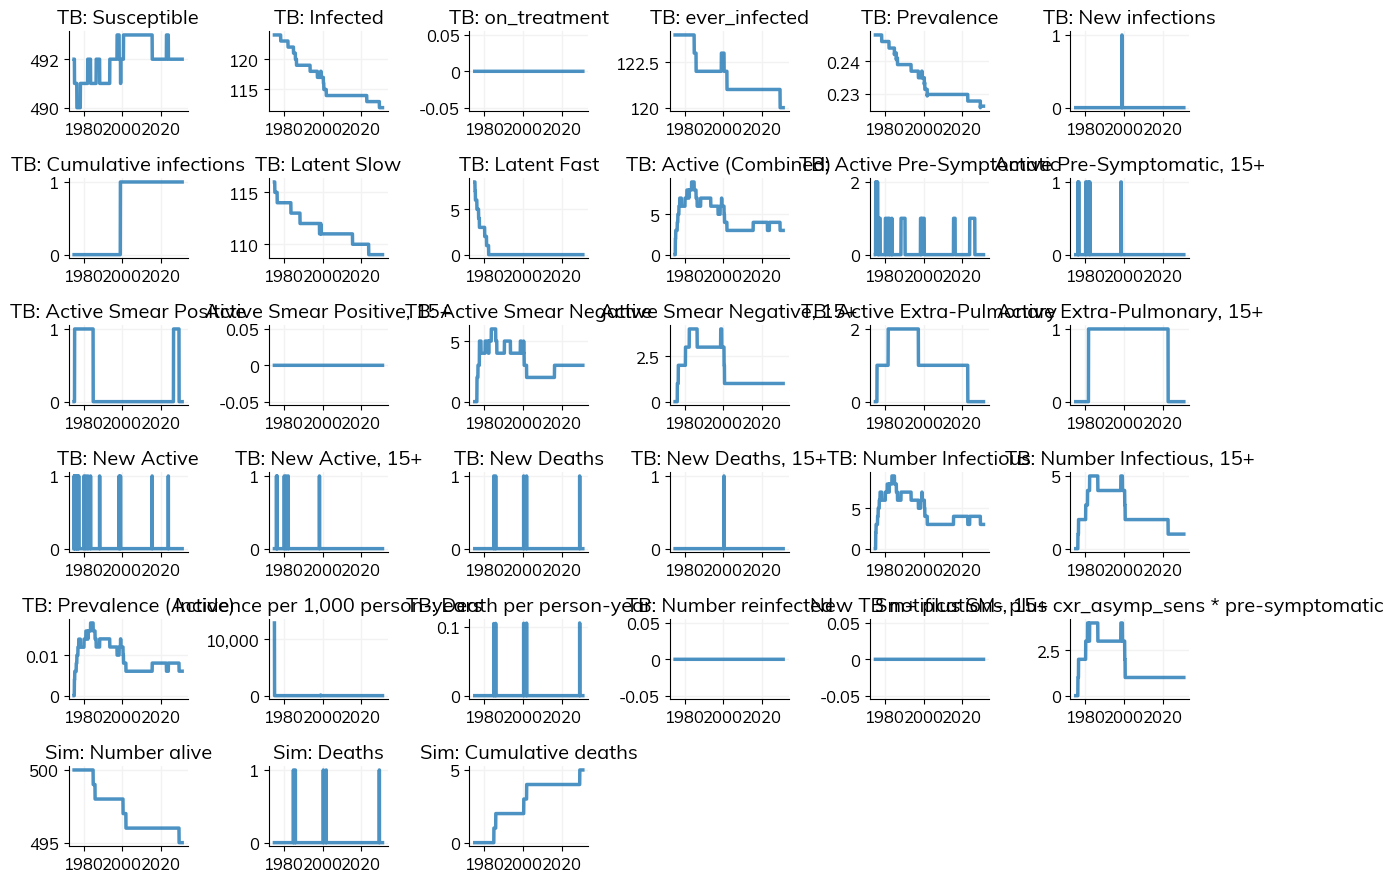

In [7]:
baseline_sim.plot()

## Running Multiple Scenarios

Now let's run multiple scenarios to compare the effects of different interventions:

In [8]:
def run_scenarios(scenario_names=None, plot=True):
    """Run multiple scenarios and optionally plot results."""
    
    all_scenarios = get_scenarios()
    
    if scenario_names is None:
        scenario_names = ['Baseline', 'Single BCG', 'TPT Intervention']
    
    results = {}
    
    for name in scenario_names:
        if name in all_scenarios:
            print(f"\nRunning: {name}")
            scenario = all_scenarios[name]
            sim = build_sim(scenario=scenario)
            sim.run()
            results[name] = sim.results.flatten()
        else:
            print(f"Warning: Scenario '{name}' not found")
    
    if plot:
        mtb.plot_combined(results)
    
    return results

# Run selected scenarios
selected_scenarios = ['Baseline', 'Single BCG']



## Creating Comparison Plots

Let's create a function to compare results across different scenarios:


Running: Baseline

Running: Single BCG


/Users/mine/newgit/newtbsim/venv/lib/python3.12/site-packages/starsim/sim.py:579: RuntimeWarning: 
The following methods are required, but were not called.
Did you mistype a method name, forget a super() call,
or did part of the sim not run (e.g. zero infections)?
<class 'tbsim.interventions.bcg.BCGProtection'>: Module.init_results

  ss.warn(errormsg)


Saved figure to /Users/mine/newgit/newtbsim/docs/tutorials/results/scenarios_20250901_004107.png


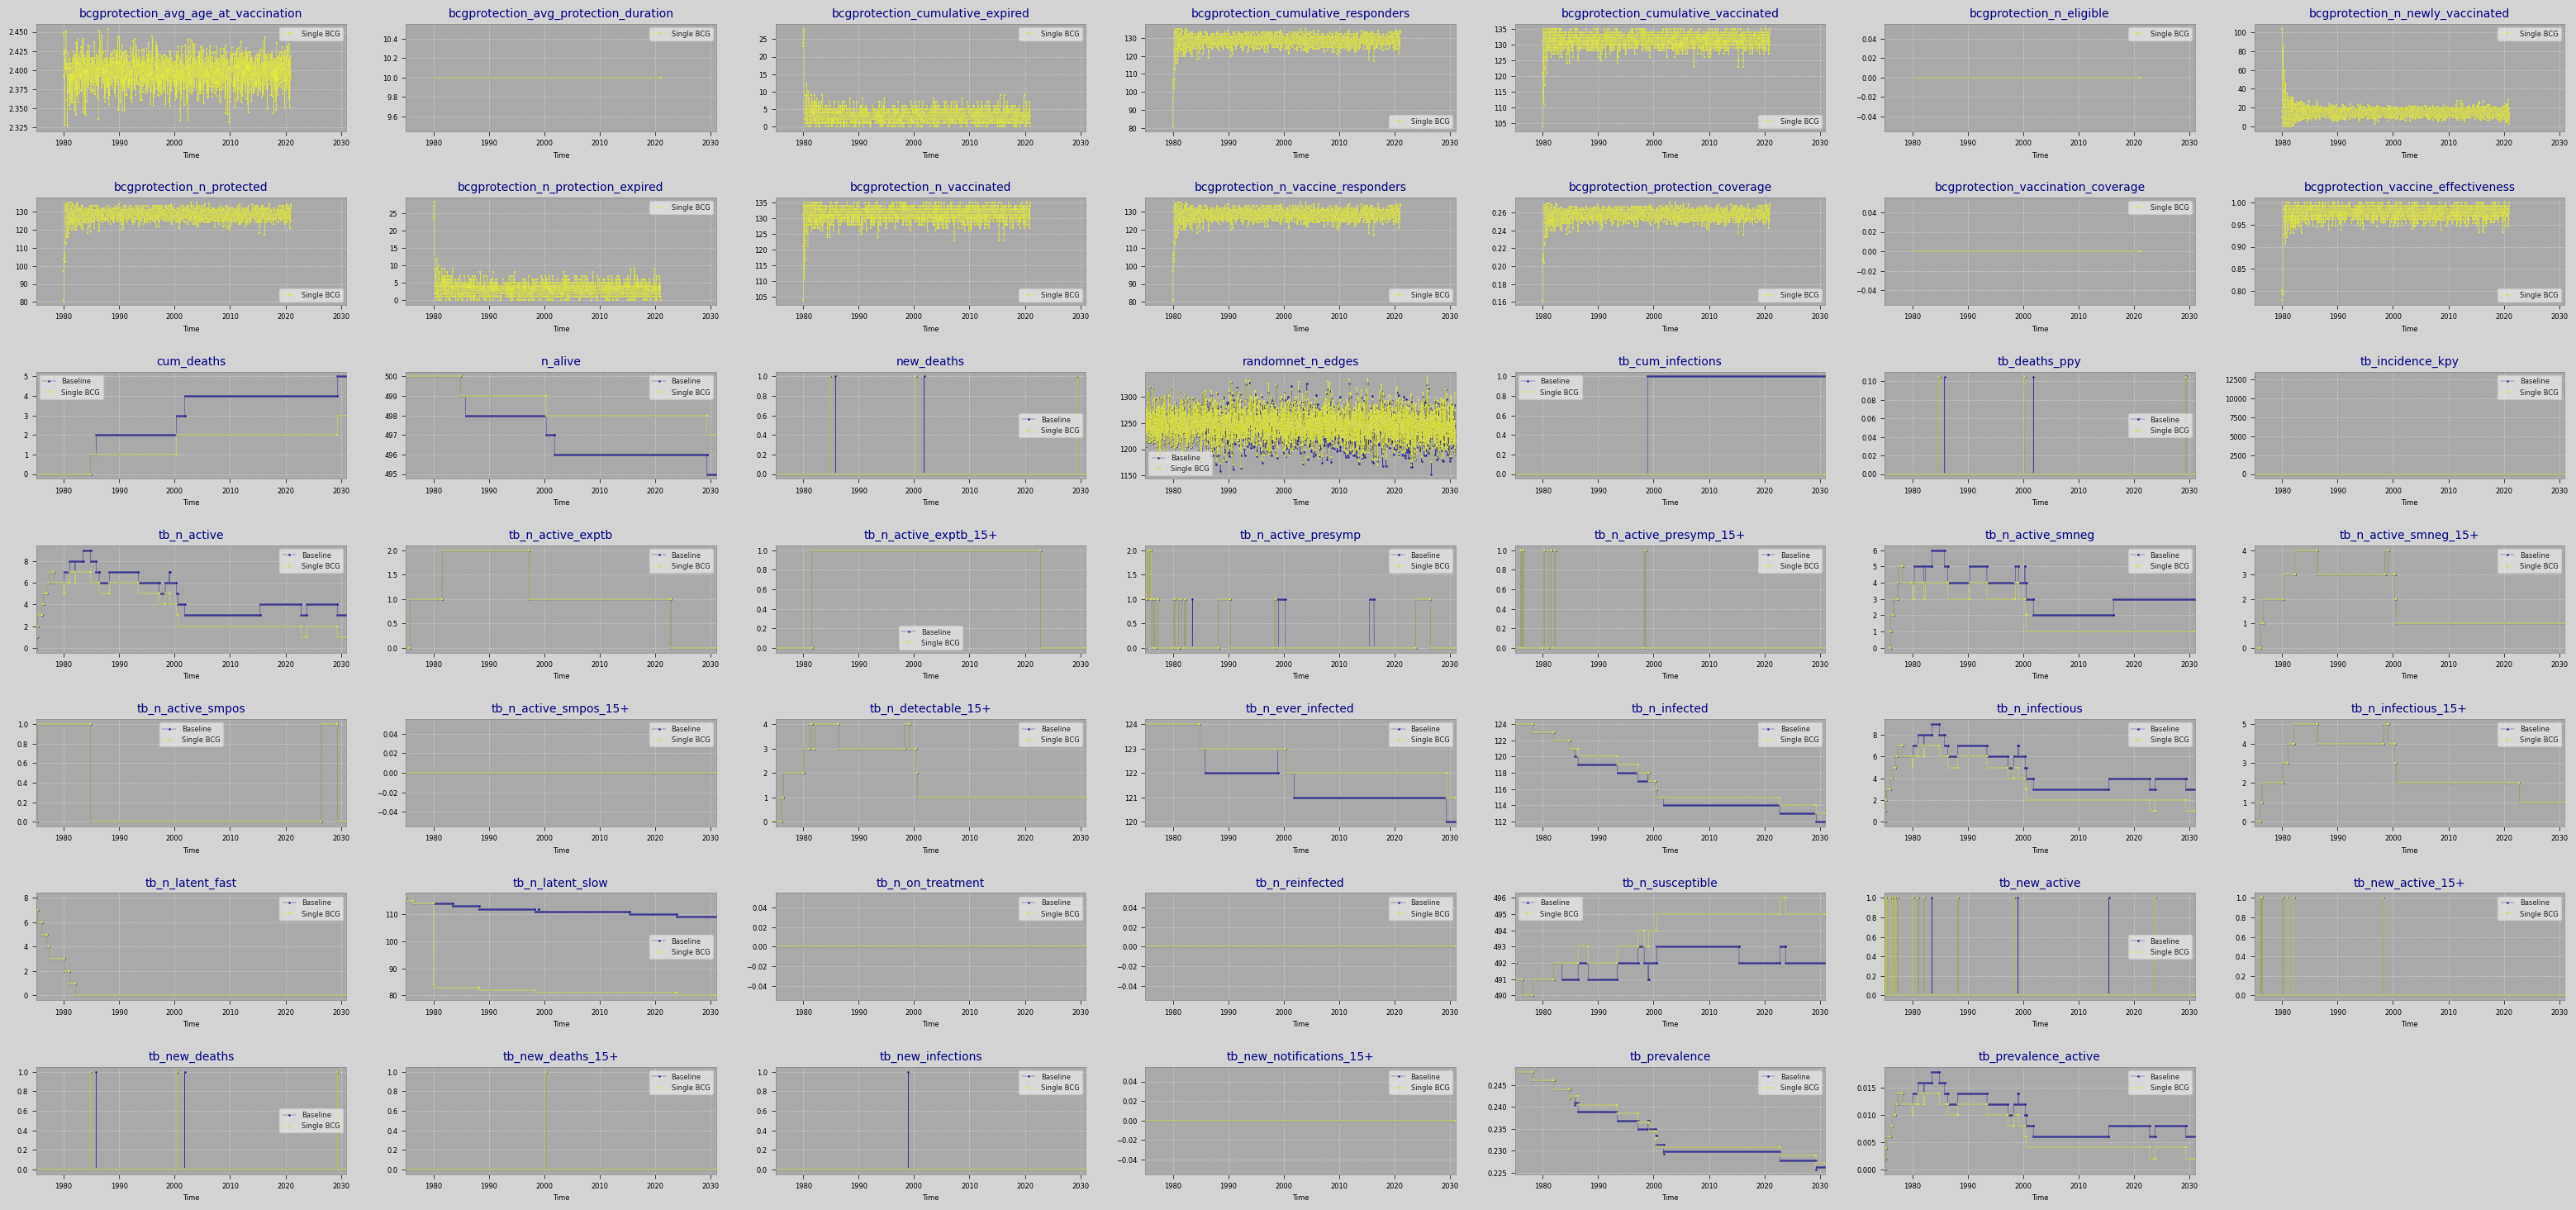

In [9]:

results = run_scenarios(selected_scenarios, plot=True)

# print(f"\nCompleted {len(results)} scenarios successfully!")

## Intervention Impact Analysis

Let's analyze the impact of interventions by calculating key metrics:

In [10]:
def analyze_intervention_impact(results):
    """Analyze the impact of interventions compared to baseline."""
    
    if 'Baseline' not in results:
        print("Warning: Baseline scenario not found for comparison")
        return
    
    baseline = results['Baseline']
    
    print("Intervention Impact Analysis (compared to Baseline):")
    print("=" * 60)
    
    for name, result in results.items():
        if name == 'Baseline':
            continue
            
        print(f"\n{name}:")
        
        # Compare final prevalence
        if 'tb_prevalence' in result and 'tb_prevalence' in baseline:
            baseline_final = baseline['tb_prevalence'][-1]
            intervention_final = result['tb_prevalence'][-1]
            reduction = ((baseline_final - intervention_final) / baseline_final) * 100
            print(f"  Final TB Prevalence: {intervention_final:.3f} (vs {baseline_final:.3f})")
            print(f"  Prevalence Reduction: {reduction:.1f}%")
        
        # Compare cumulative deaths
        if 'tb_deaths' in result and 'tb_deaths' in baseline:
            baseline_deaths = np.sum(baseline['tb_deaths'])
            intervention_deaths = np.sum(result['tb_deaths'])
            death_reduction = ((baseline_deaths - intervention_deaths) / baseline_deaths) * 100
            print(f"  Total TB Deaths: {intervention_deaths:.0f} (vs {baseline_deaths:.0f})")
            print(f"  Death Reduction: {death_reduction:.1f}%")
        
        # Compare average incidence
        if 'tb_incidence' in result and 'tb_incidence' in baseline:
            baseline_avg_incidence = np.mean(baseline['tb_incidence'])
            intervention_avg_incidence = np.mean(result['tb_incidence'])
            incidence_reduction = ((baseline_avg_incidence - intervention_avg_incidence) / baseline_avg_incidence) * 100
            print(f"  Average Incidence: {intervention_avg_incidence:.3f} (vs {baseline_avg_incidence:.3f})")
            print(f"  Incidence Reduction: {incidence_reduction:.1f}%")

# Run the analysis
analyze_intervention_impact(results)

Intervention Impact Analysis (compared to Baseline):

Single BCG:
  Final TB Prevalence: 0.227 (vs 0.226)
  Prevalence Reduction: -0.5%


## Advanced: Custom Scenario Creation

Let's create a custom scenario to demonstrate how to define your own interventions:

Custom scenario created:
  Name: Combined BCG + TPT + Beta Reduction
  BCG coverage: 0.85
  Beta reduction: [0.8, 0.6, 0.4]

Running custom scenario...
At year:1990, Modified BetaValue:0.8
At year:2000, Modified BetaValue:0.6
At year:2010, Modified BetaValue:0.4


/Users/mine/newgit/newtbsim/venv/lib/python3.12/site-packages/starsim/sim.py:579: RuntimeWarning: 
The following methods are required, but were not called.
Did you mistype a method name, forget a super() call,
or did part of the sim not run (e.g. zero infections)?
<class 'tbsim.interventions.bcg.BCGProtection'>: Module.init_results

  ss.warn(errormsg)


Custom scenario completed!
Saved figure to /Users/mine/newgit/newtbsim/docs/tutorials/results/scenarios_20250901_004115.png


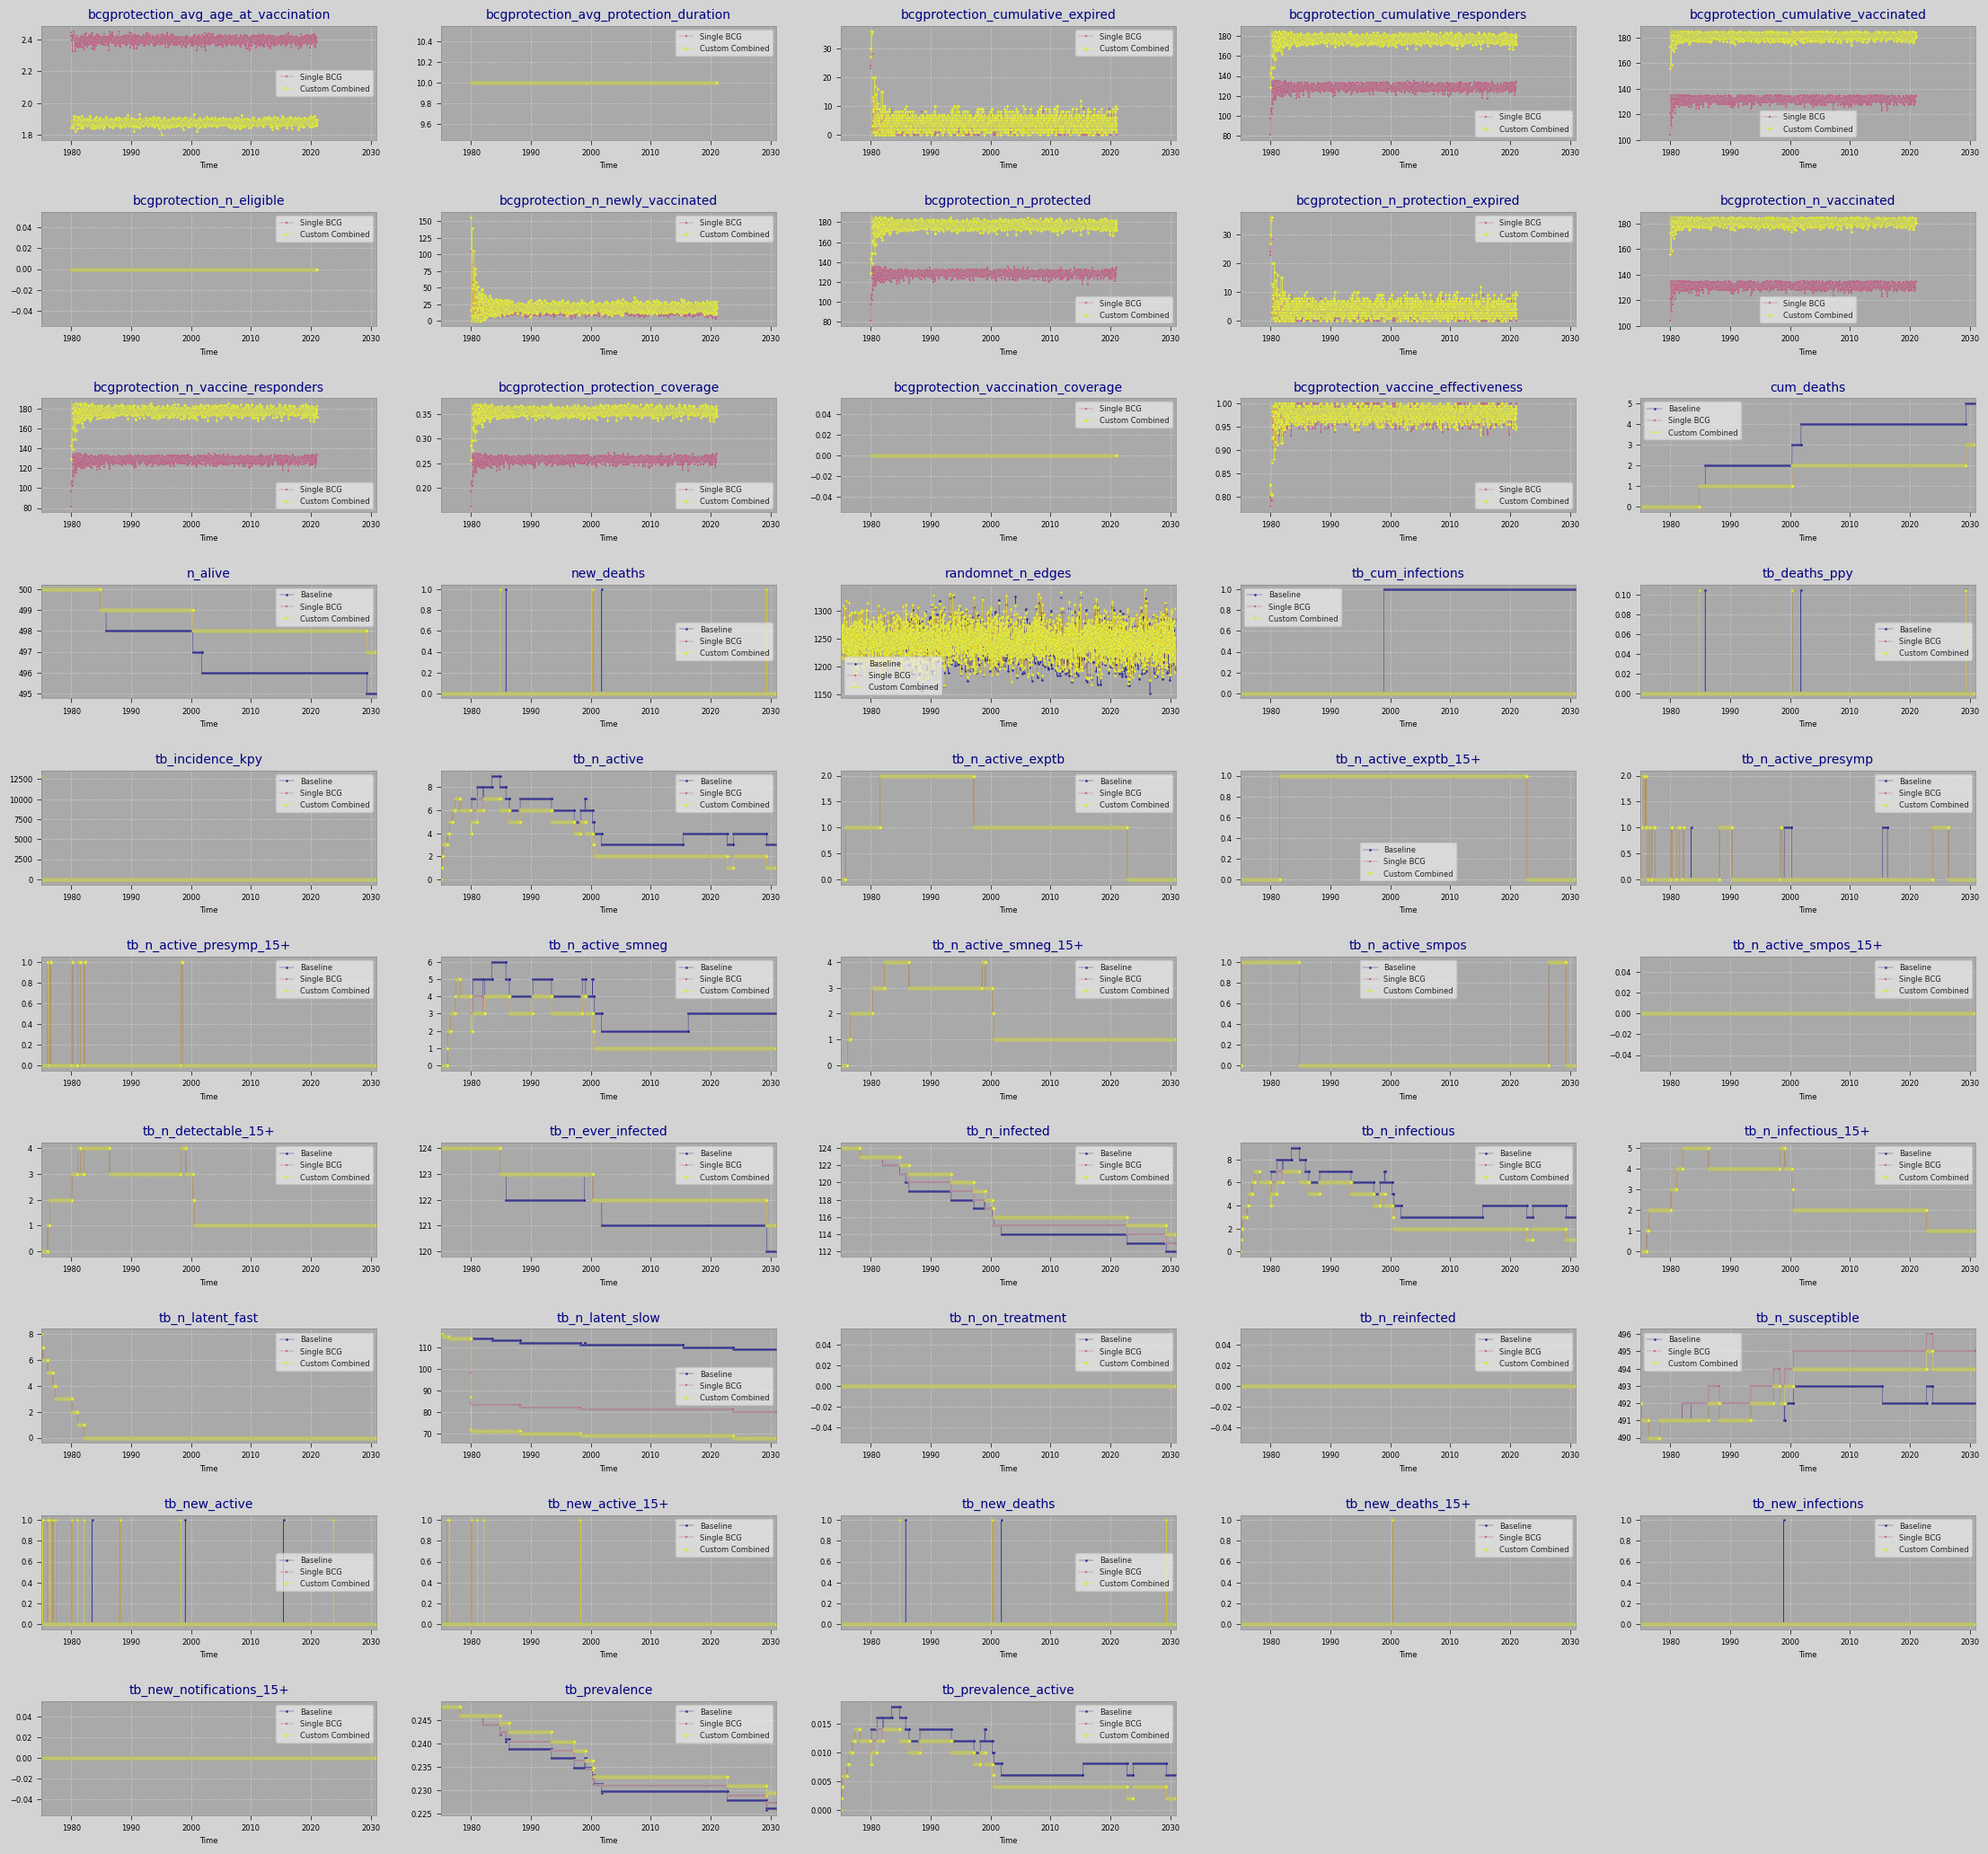

In [11]:
# Create a custom scenario with multiple interventions
custom_scenario = {
    'name': 'Combined BCG + TPT + Beta Reduction',
    'tbpars': dict(
        start=ss.date('1975-01-01'), 
        stop=ss.date('2030-12-31'),
        beta=0.0020  # Lower baseline transmission
    ),
    'bcgintervention': dict(
        coverage=0.85,
        start=ss.date('1980-01-01'),
        stop=ss.date('2020-12-31'),
        age_range=[0, 5],
    ),
    'betabyyear': dict(
        years=[1990, 2000, 2010], 
        x_beta=[0.8, 0.6, 0.4]  # Gradual reduction in transmission
    )
}

print("Custom scenario created:")
print(f"  Name: {custom_scenario['name']}")
print(f"  BCG coverage: {custom_scenario['bcgintervention']['coverage']}")
print(f"  Beta reduction: {custom_scenario['betabyyear']['x_beta']}")

# Run the custom scenario
print("\nRunning custom scenario...")
custom_sim = build_sim(scenario=custom_scenario)
custom_sim.run()
custom_results = custom_sim.results.flatten()

print("Custom scenario completed!")

# Add to results for comparison
results['Custom Combined'] = custom_results

mtb.plot_combined(results, n_cols=5)

## Summary and Key Takeaways

In this tutorial, we've learned how to:

1. **Build TB simulations** with intervention capabilities using `tbsim` and `starsim`
2. **Define different intervention types**:
   - **BCG vaccination**: Reduces TB transmission and severity
   - **TPT (Tuberculosis Preventive Therapy)**: Prevents progression from latent to active TB
   - **Beta changes**: Modifies transmission rates over time
3. **Run multiple scenarios** and compare their impacts
4. **Analyze intervention effectiveness** through key metrics like prevalence, incidence, and mortality
5. **Create custom scenarios** with multiple interventions

### Key Findings:

- **BCG vaccination** shows significant impact on reducing TB prevalence, especially when targeting young children
- **TPT interventions** can be effective in reducing TB incidence and mortality
- **Combined interventions** often provide the best outcomes
- **Transmission rate modifications** (beta changes) can simulate public health measures or environmental changes

### Next Steps:

You can extend this tutorial by:
- Exploring different parameter combinations
- Adding more complex intervention scenarios
- Incorporating additional comorbidities (HIV, malnutrition)
- Analyzing cost-effectiveness of interventions
- Running sensitivity analyses on key parameters

## References and Further Reading

- **tbsim documentation**: For detailed API reference and advanced features
- **starsim documentation**: For general simulation framework capabilities
- **TB modeling literature**: For epidemiological context and validation
- **Intervention studies**: For real-world intervention effectiveness data

This tutorial provides a foundation for TB intervention modeling that can be adapted for specific research questions and policy analysis.